In [1]:
import numpy as np
import pandas as pd
import sys
import sqlite3

import matplotlib
matplotlib.use
import matplotlib.pyplot as plt
plt.style.use('plotting.mplstyle')

In [2]:
sys.path.insert(0, '/home/nsryan/Desktop/arfc/transition-scenarios/scripts')
mycolors = ["#332288", "#117733", "#44AA99", "#88CCEE", "#DDCC77", "#CC6677", "#AA4499", "#882255"]

In [3]:
import cymetric as cym
from cymetric import graphs
import transition_metrics as tm
import dataframe_analysis as dta
import analysis as an
import collections

import nuclides
import fuel_transactions as tran

In [4]:
current_outfile = f'old_reactor_100.sqlite'

In [5]:
db = cym.dbopen(current_outfile)
evaler = cym.Evaluator(db, write=False)
# graphs.flow_graph(evaler, label='com')

In [6]:
currents = ['Sink', 'Source', 'Base_Reactor', 'United States', 'FuelCycle']

In [7]:
current_reactors = tm.get_lwr_totals(current_outfile, currents)
current_reactors = dta.add_year(current_reactors, y0=2024)

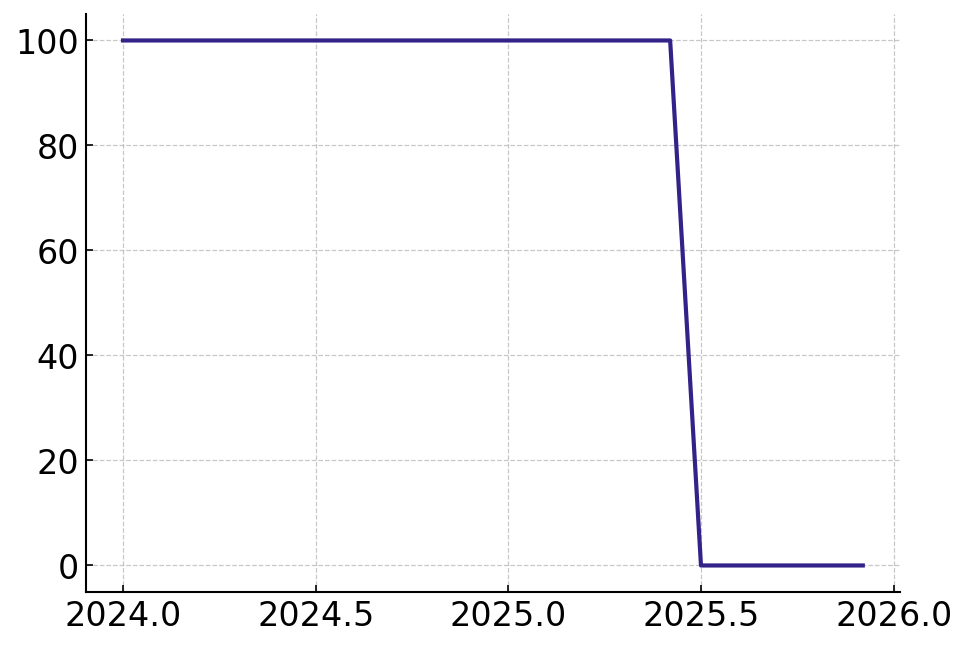

In [8]:
reactor_number = current_reactors['Base_Reactor_enter'].cumsum() + current_reactors['Base_Reactor_exit'].cumsum()

plt.plot(current_reactors['Year'], reactor_number, label='Current')

In [9]:
current_energy = tm.get_monthly_electricity(current_outfile, y0=2024)

In [10]:
current_energy

,Year,Energy
0,2024.000000,100.0
1,2024.083333,100.0
2,2024.166667,100.0
3,2024.250000,0.0
4,2024.333333,0.0
5,2024.416667,100.0
6,2024.500000,100.0
7,2024.583333,100.0
8,2024.666667,0.0
9,2024.750000,0.0


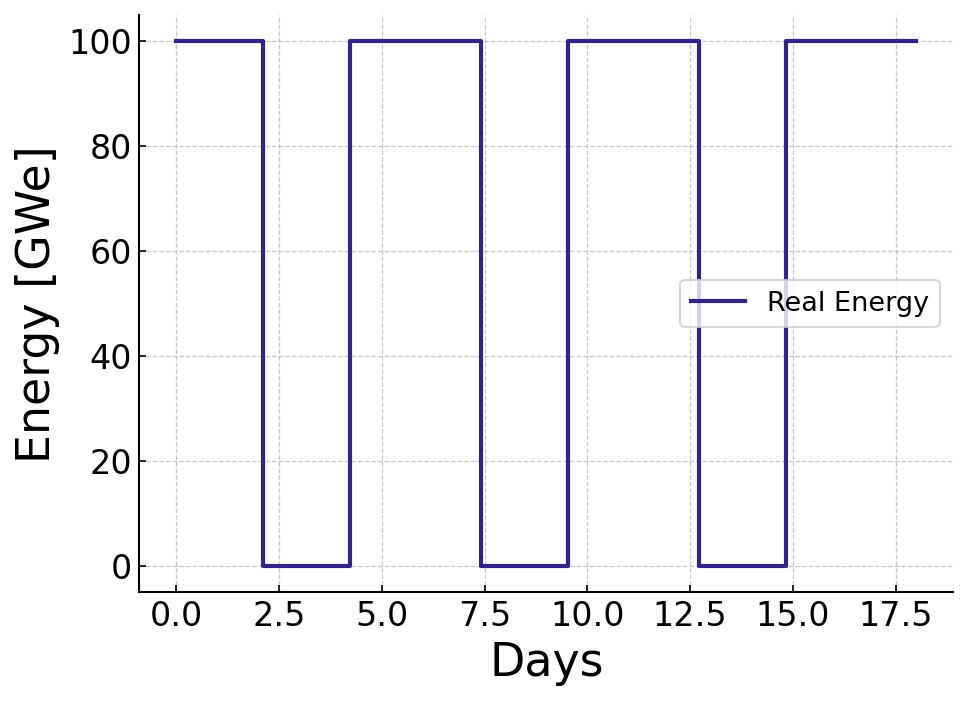

In [11]:
days = np.linspace(0,18,18)

plt.step(days, current_energy['Energy'], label='Real Energy', where='pre')
# plt.plot(days, [current_energy['Energy'][1]]*len(days), label='Approximated Energy')

plt.xlabel('Days')
plt.ylabel('Energy [GWe]')

plt.legend()

In [12]:
current_transactions = tm.add_receiver_prototype(current_outfile)
current_uox = dta.commodity_mass_traded(current_transactions, 'fresh_uox')

In [13]:
current_uox

,Time,Quantity,Year
0,0,9900000.0,1958.00
1,1,0.0,1958.08
2,2,0.0,1958.17
3,3,3300000.0,1958.25
4,4,0.0,1958.33
...,...,...,...
1747,1747,0.0,2103.58
1748,1748,0.0,2103.67
1749,1749,0.0,2103.75
1750,1750,0.0,2103.83


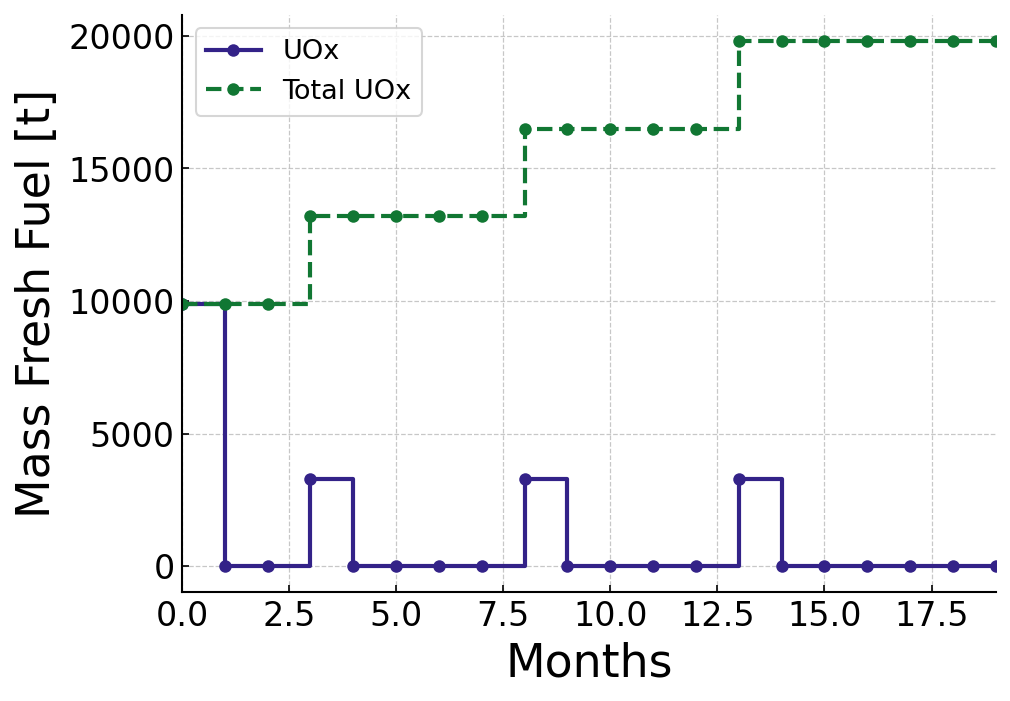

In [14]:
plt.step(current_uox['Time'], current_uox['Quantity']/1000, label='UOx', where='post', marker='o')
plt.step(current_uox['Time'], current_uox['Quantity'].cumsum()/1000, label='Total UOx', linestyle='--', where='post', marker='o')


plt.ylabel('Mass Fresh Fuel [t]')
plt.xlabel('Months')
plt.xlim(0, 19)

plt.legend()

In [15]:
used_uox = dta.commodity_mass_traded(current_transactions, 'used_uox')

In [16]:
used_uox

,Time,Quantity,Year
0,0,0.0,1958.00
1,1,0.0,1958.08
2,2,0.0,1958.17
3,3,3300000.0,1958.25
4,4,0.0,1958.33
...,...,...,...
1747,1747,0.0,2103.58
1748,1748,0.0,2103.67
1749,1749,0.0,2103.75
1750,1750,0.0,2103.83


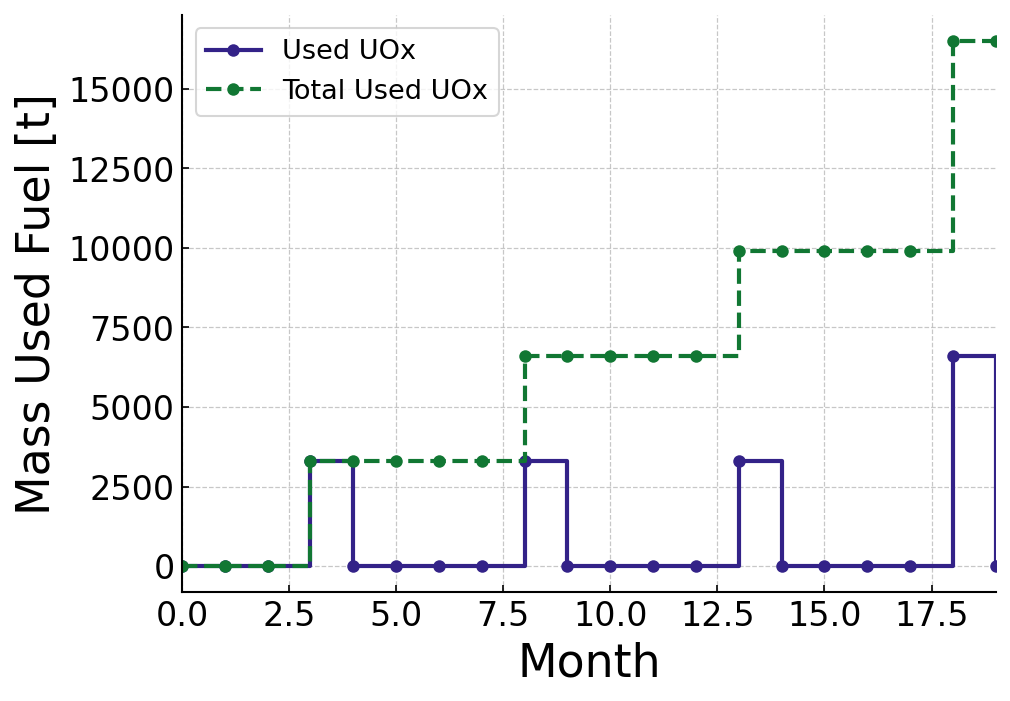

In [17]:
plt.step(used_uox['Time'], used_uox['Quantity']/1000, label='Used UOx', where='post', marker='o')
plt.step(used_uox['Time'], used_uox['Quantity'].cumsum()/1000, label='Total Used UOx', linestyle='--', where='post', marker='o')


plt.ylabel('Mass Used Fuel [t]')
plt.xlabel('Month')
plt.xlim(0, 19)

plt.legend()

In [18]:
#Defining assays for LEU product, tails, and feed material
leu_p = 0.045
mmrh_p = 0.1975
mmrl_p = 0.0995
xeh_p = 0.155
xel_p = 0.0995
x_f = 0.00711
x_t = 0.002

In [19]:
current_tails_lwr = dta.calculate_tails(current_uox['Quantity'], leu_p, x_t, x_f)
current_feed_lwr = dta.calculate_feed(current_uox['Quantity'], current_tails_lwr)
current_swu_lwr = dta.calculate_SWU(current_uox['Quantity'], leu_p,
                               current_tails_lwr, x_t,
                               current_feed_lwr, x_f)
current_swu_lwr = current_swu_lwr.to_frame().reset_index()
current_swu_lwr = current_swu_lwr.rename(columns={'Quantity':'SWU', 'index':'Time'})
current_swu_lwr = dta.add_year(current_swu_lwr)

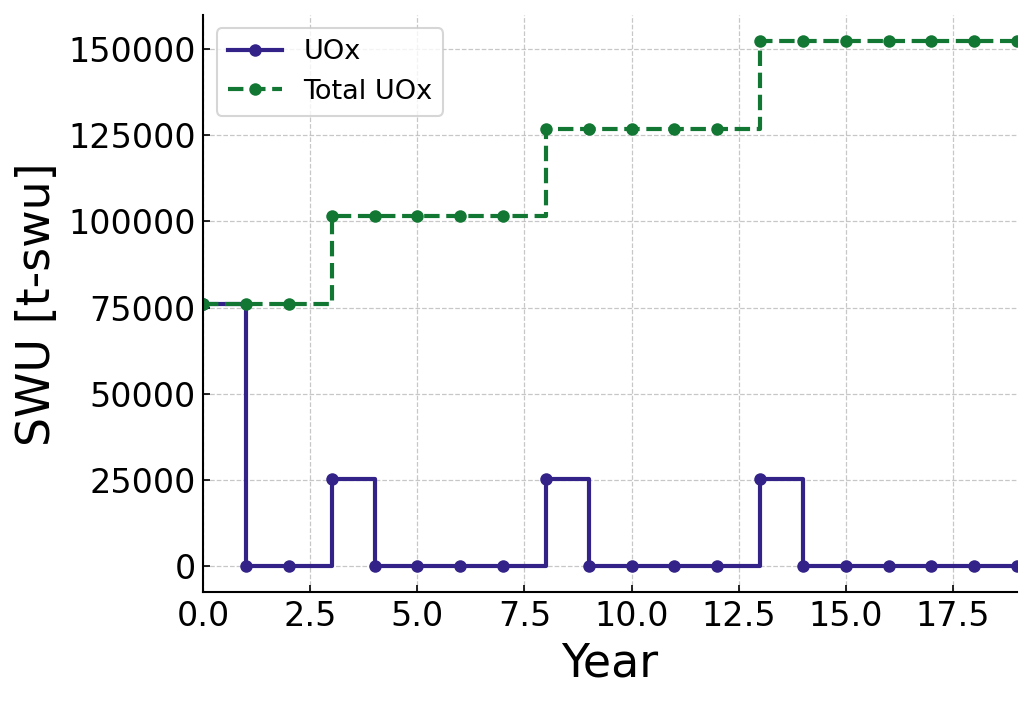

In [20]:
plt.step(current_swu_lwr['Time'], current_swu_lwr['SWU']/1000, label='UOx', where='post', marker='o')
plt.step(current_swu_lwr['Time'], current_swu_lwr['SWU'].cumsum()/1000, label='Total UOx', linestyle='--', where='post', marker='o')


plt.ylabel('SWU [t-swu]')
plt.xlabel('Year')
plt.xlim(0, 19)

plt.legend()